In [1]:
import numpy as np
import scipy.stats as sc
import pandas as pd
import matplotlib.pyplot as plt
import folium

In [2]:
review_fields = ['review_id', 'user_id', 'business_id', 'stars', 'date']
review_fields2 = ['user_id', 'business_id', 'stars']
business_fields = ['business_id', 'name', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'categories', 'is_open']
user_fields = ['user_id', 'name', 'review_count', 'yelping_since', 'average_stars']

In [14]:
prefix = ''#"/Users/Dominic/Downloads/"
business_df = pd.read_csv(prefix + "yelp_business.csv", usecols=business_fields)
review_chunks = pd.read_csv(prefix + "yelp_review.csv",usecols=review_fields,chunksize=500000)
users = pd.read_csv(prefix + "yelp_user.csv",usecols=user_fields)
reviews_raw = pd.read_csv(prefix + "yelp_review.csv",usecols=review_fields2)
business_hours = pd.read_csv(prefix + "yelp_business_hours.csv")

In [15]:
class Sampleable:
    def __init__(self, sample):
        self.sample = self.__mutate(sample)
        assert isinstance(self.sample, pd.core.frame.DataFrame)
        self.sample.dropna()
        self.sample_size = 0
            
    def __mutate(self, sample):
        if isinstance(sample, pd.io.parsers.TextFileReader):
            for s in sample: sample = s; break
        return sample
    
    def getType(self):
        return self.type
    
    def getSample(self, n_samples):
        self.sample_size = n_samples
        rows = np.random.choice(self.sample.index.values, n_samples)
        return self.sample.iloc[rows]
    
    def getOrderedSample(self, n_samples):
        return self.sample.head(n_samples)
    
    def randomMutate(self, new_sample):
        self.sample = self.__mutate(new_sample)
    
businessSampler = Sampleable(business_df)
reviewSampler = Sampleable(review_chunks)
userSampler = Sampleable(users)
businessHoursSampler = Sampleable(business_hours)

In [16]:
b_samp = businessSampler.getSample(50000)
h_samp = businessHoursSampler.getSample(50000)

In [79]:
week = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
def remove_none(sample):
    for day in week:
        sample = sample[sample[day] != 'None']
    return sample

def times_to_hours_2(text):
    text = text.split('-')
    if len(text) < 2:
        return 0
    start = text[0].split(':')
    end = text[1].split(':')
    hours = int(end[0]) - int(start[0])
    mins = int(end[1]) - int(start[1])
    return abs(round(float(hours) + (float(mins) / 60.), 1))

def times_to_hours(row):
    sum1 = 0.
    for day in week:
        sum1 = sum1 + times_to_hours_2(row[day])
    return round(sum1 / 7., 2)
#print(times_to_hours('4:30-22:10'))

In [81]:
#h_samp.replace('None', None)
#remove_none(h_samp).describe()
sample = remove_none(h_samp)
#sample.count()
#sample[83905]
#sample.head()
sample['hours_open'] = sample.apply(times_to_hours, axis = 1)
#sample.head()

In [82]:
sample2 = sample[['business_id', 'hours_open']].join(business_df.set_index('business_id'), on='business_id', lsuffix='_l',rsuffix='_r')
sample2.head()

,business_id,hours_open,name,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
83905,rAUdaM-mBLSBu79hNNnODA,10.00,"""Brunel""",Edinburgh,EDH,EH3 9NY,55.941519,-3.210350,4.0,4,0,Coffee & Tea;Food
116879,00Hwe34krmUvWqMYqbIOHQ,6.14,"""Laser Quest""",Mississauga,ON,L4Y 4A2,43.605942,-79.587626,4.5,5,1,Party & Event Planning;Active Life;Laser Tag;E...
125463,_quVlmD-dxLi3y3k8t1izg,7.86,"""Century Cycles""",Peninsula,OH,44264,41.241251,-81.549329,4.5,15,1,Active Life;Sporting Goods;Bike Repair/Mainten...
41023,OYaL_-uxBCgrE94uNQ4VCA,9.00,"""Lino's Pizzeria & Italian Cuisine""",Las Vegas,NV,89130,36.274484,-115.252556,4.0,96,1,Food;Italian;Salad;Desserts;Pizza;Sandwiches;R...
172562,eR7Iw_X54m3YLWkXp9y35Q,5.21,"""Tonkatsu Kiyoshi""",Las Vegas,NV,89139,36.047985,-115.224432,4.5,477,1,Food;Restaurants;Specialty Food;Japanese;Ethni...


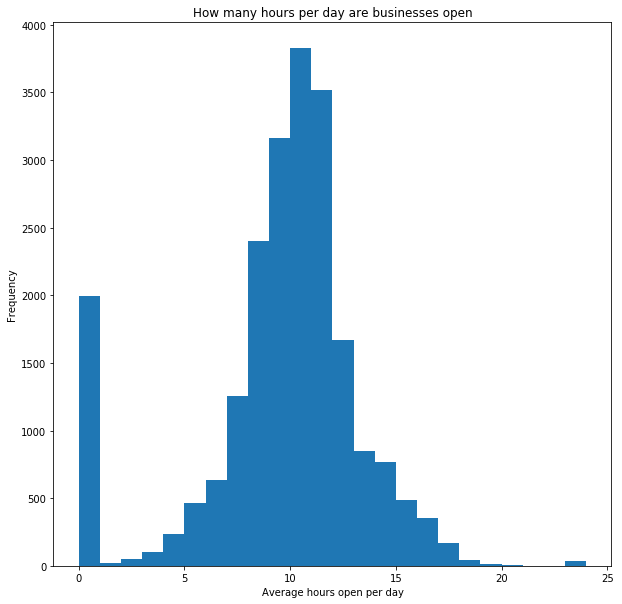

In [91]:
plt.figure(figsize=(10,10))
plt.hist(sample2['hours_open'], range=(0,24), bins=24)
plt.xlabel('Average hours open per day')
plt.ylabel('Frequency')
plt.title('How many hours per day are businesses open')
plt.show()

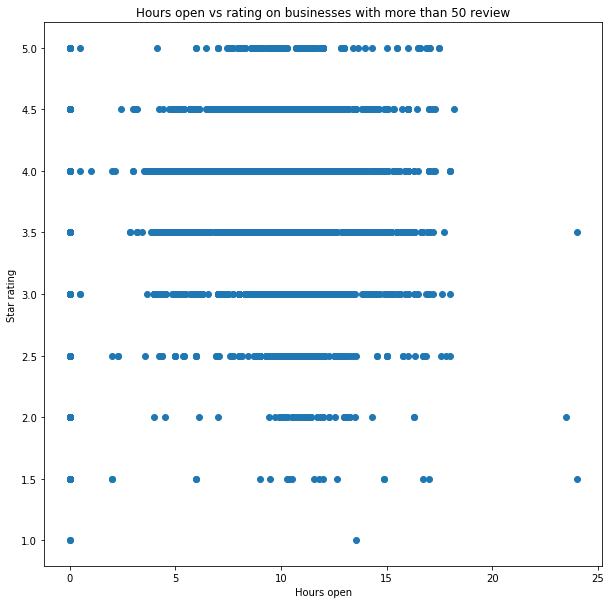

In [92]:
plt.figure(figsize=(10,10))
plt.scatter(sample2[sample2['review_count'] > 50]['hours_open'],sample2[sample2['review_count'] > 50]['stars'])
plt.xlabel('Hours open')
plt.ylabel('Star rating')
plt.title('Hours open vs rating on businesses with more than 50 review')
plt.show()

In [93]:
sample2['hours_open'].corr(sample2['stars'])

-0.030601027257594206

In [95]:
focused_sample = b_samp[(b_samp['longitude'] < -50) & (b_samp['latitude'] <= 60) & (b_samp['latitude']>=0)]
len(focused_sample)

47740

In [96]:
def get_map_color(stars):
    if stars >= 4.5:
        return 'green'
    if stars >= 3.5:
        return 'lightgreen'
    if stars >= 2.5:
        return 'red'
    return 'darkred'

In [98]:
m = folium.Map(location=[20, 0], tiles="Mapbox Bright", zoom_start=2)

for index, row in focused_sample.head(100).iterrows():
    s = "{} ({})".format(row['name'].strip("\"").replace("'", ""),row['stars'])
    folium.Marker([row['latitude'], row['longitude']], popup=s, icon=folium.Icon(color=get_map_color(row['stars'])).add_to(m)
m

SyntaxError: invalid syntax (<ipython-input-98-aa0be565326c>, line 6)